# Cross-Sectional Area Based Filter

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aladinor/Ladino_et_al_2024_DNN_PSD_retrieval/blob/main/notebooks/1.CSAB-filter.ipynb)

Sets up the environment and data path based on whether the notebook is running in Colab or locally.

In [1]:
if 'google.colab' in str(get_ipython()):
    !wget https://raw.githubusercontent.com/aladinor/Ladino_et_al_2025_DNN_PSD_retrieval/main/scripts/colab_setup.py -O colab_setup.py
    %run colab_setup.py
    path = '/content/Ladino_et_al_2025_DNN_PSD_retrieval/'
else:
    print("Running notebook locally")
    path = '..'

Running notebook locally


In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.transforms as mtransforms
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from collections import Counter
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch, Rectangle
from matplotlib.offsetbox import DrawingArea
from metpy.calc import pressure_to_height_std as p2h
from metpy.calc import lcl
import warnings
from PIL import Image
import cv2
warnings.filterwarnings('ignore')

Let's fire up our local cluster

In [3]:
cluster = LocalCluster()  
# display(cluster)

Now, we can access our dataset which is stored in a `Xarray.DataTree` object

In [5]:
dt_camp2ex = xr.open_datatree(
    f'{path}/data/camp2ex_dtree.zarr', 
    engine='zarr', 
    consolidated=True, 
    chunks={}
)

Then, we can access the HVPS data by using the path `"/Lear/HVPS"`

In [6]:
xr_hvps = dt_camp2ex["/Lear/HVPS"].to_dataset()

In [7]:
display(xr_hvps)

<xarray.Dataset> Size: 282MB
Dimensions:        (time: 136130, diameter: 61)
Coordinates:
  * diameter       (diameter) float64 488B 150.0 300.0 ... 4.357e+04 4.656e+04
  * time           (time) datetime64[ns] 1MB 2019-09-07T00:29:45 ... 2019-09-...
Data variables: (12/19)
    NevLWC         (time) float64 1MB dask.array<chunksize=(35681,), meta=np.ndarray>
    NevTWC         (time) float64 1MB dask.array<chunksize=(35681,), meta=np.ndarray>
    Temp           (time) float64 1MB dask.array<chunksize=(34033,), meta=np.ndarray>
    a_bin          (time, diameter) float64 66MB dask.array<chunksize=(17017, 8), meta=np.ndarray>
    alt            (time) float64 1MB dask.array<chunksize=(35680,), meta=np.ndarray>
    cnt_bin        (time, diameter) float64 66MB dask.array<chunksize=(17017, 8), meta=np.ndarray>
    ...             ...
    meanDiameter   (time) float64 1MB dask.array<chunksize=(34033,), meta=np.ndarray>
    meanVolDiam    (time) float64 1MB dask.array<chunksize=(34033,), meta=np.ndarray>
    psd            (time, diameter) float64 66MB dask.array<chunksize=(17017, 8), meta=np.ndarray>
    sv             (time) float64 1MB dask.array<chunksize=(34033,), meta=np.ndarray>
    totaln         (time) float64 1MB dask.array<chunksize=(34033,), meta=np.ndarray>
    twc            (time) float64 1MB dask.array<chunksize=(34033,), meta=np.ndarray>
Attributes:
    aircraft:    Learjet
    bin_cent:    [150.0, 300.0, 450.0, 600.0, 750.0, 900.0, 1050.0, 1200.0, 1...
    dsizes:      [150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150...
    instrument:  HVPS
    psd_units:   [' #/liter/um']
    sizes:       [75.0, 225.0, 375.0, 525.0, 675.0, 825.0, 975.0, 1125.0, 127...
    type:        HVPS

Now, we can estimate the axis ratio ($\alpha$) defined by Andsager et al. (1998)

In [8]:
# lets create a array from the min diameter to the max diameter every 0.1
diameter= np.arange(xr_hvps.diameter.min() / 1e3, xr_hvps.diameter.max() / 1e3, 0.1)
ar_andsager = lambda d: 1.0048 + 0.0057 * d - 2.628 * d ** 2 + 3.682 * d ** 3 - \
                                                          1.677 * d ** 4
# axis ratio for the diameter array
alpha = ar_andsager(diameter/10)
# axis ratio for each bin within the HVPS
alpha_hvps = ar_andsager(xr_hvps.diameter/1e4)


Once we create the axis ratio, we can create a corresponding cross-sectional area

In [9]:
# area function
_area = lambda x: np.pi * (x / 2) ** 2

# Cross-sectional area for a sphere
area = _area(diameter)
# Cross-sectional area at each bin 
area_hvps = _area(xr_hvps.diameter / 1e3)

Splashed particle was detected during a cloud penetration by the Learjet aircraft on `2019-09-07 02:32:12`

In [10]:
time = "2019-09-07 02:32:12"

Let's extract the PSD and the bin width for this measurement

In [11]:
psd = (xr_hvps.sel(time=time).psd * 1e6) 
d_D = xr_hvps.sel(time=time).d_d

Now, we can compute the raw LWC and get the Nevzorov values

In [12]:
lwc_raw = ((np.pi / (6*1000)) * psd * (xr_hvps.diameter/1e3) ** 3 * d_D / 1e3)
lwc_raw_tot = lwc_raw.sum("diameter").squeeze().values
lwc_nev = xr_hvps.NevTWC.sel(time=time).values
llwc_nev = xr_hvps.NevLWC.sel(time=time).values

In [13]:
lwc_nev, llwc_nev

(array(1.2), array(1.6))

The Cross-sectional Area (CSA) for each bin can be estimated as:

$$CSAB_{i} = \frac{A(D_{i})}{N(D_{i})}$$

Where $A$ is the Area at each $i$ bin, and PN is the number of particles within the $i$ bin. 

In [14]:
csa = xr_hvps.a_bin.sel(time=time) /  xr_hvps.cnt_bin.sel(time=time)

Our cross-sectional area-based filter is expressed as:

$$CSAB= \frac{\pi}{4}D^2*\alpha$$

Now, we can filter bins with the axis ratio $ 1<= \alpha <=2$ 

In [15]:
## Particles accepted
csab_in = csa.where(csa >= area_hvps / 1e5 * alpha_hvps).where(csa <= area_hvps / 1e5 * alpha_hvps * 2)
## Particles Rejected in the upper bound
csab_low = csa.where(csa < area_hvps / 1e5 * alpha_hvps)
## Particles Rejected in the lower bound
csab_up = csa.where(csa > area_hvps / 1e5 * alpha_hvps * 2)

Let's estimate the LWC filtered

In [16]:
lwc_filt = lwc_raw.where(csa >= area_hvps / 1e5 * alpha_hvps).where(csa <= area_hvps / 1e5 * alpha_hvps * 2)

To confirm the measurements were taken within a cloud, we only keep data with at least 5 consecutive bins wiht $N(D_i)> 0$. Therefore, we created the following fucntion:

In [17]:
def filter_consecutive(dataarray, min_length=5):
    # Ensure the input is a DataArray
    if not isinstance(dataarray, xr.DataArray):
        raise TypeError("Input must be an xarray DataArray.")
    
    # Convert the DataArray to a numpy array for manipulation
    arr = dataarray.values
    arr = np.array(arr, dtype=float)  # Ensure it is of float type to accommodate NaNs
    
    # Identify the indices where the values are neither NaNs nor zeros
    valid_indices = np.where(~np.isnan(arr) & (arr != 0))[0]
    
    # If there are no valid numbers, return an array filled with NaNs
    if len(valid_indices) == 0:
        return xr.full_like(dataarray, np.nan)
    
    # Find the indices where the difference between consecutive valid indices is not 1
    diff = np.diff(valid_indices)
    breaks = np.where(diff != 1)[0] + 1
    
    # Split the valid indices into groups based on breaks
    sequences = np.split(valid_indices, breaks)
    
    # Create a copy of the array to modify
    filtered_array = np.full_like(arr, np.nan)
    
    # Retain sequences that have at least 'min_length' consecutive elements
    for seq in sequences:
        if len(seq) >= min_length:
            filtered_array[seq] = arr[seq]
    
    # Create a new DataArray with the same coordinates, dimensions, and attributes
    filtered_dataarray = xr.DataArray(filtered_array, 
                                      coords=dataarray.coords, 
                                      dims=dataarray.dims, 
                                      attrs=dataarray.attrs)
    
    return filtered_dataarray

In [18]:
lwc_filtered = filter_consecutive(lwc_filt).sum("diameter").squeeze().values

In [19]:
lwc_filtered

array(5.95016012)

Now, we get the diameter for each filtered case

In [20]:
# similarly we stimated the 
y = xr_hvps.psd.sel(time=time) * 1e6
y = y.where(y > 0, np.nan)
yyes = y.where(csa >= area_hvps / 1e5 * alpha_hvps).where(csa <= area_hvps / 1e5 * alpha_hvps * 2)
ynot = y.where(csa < area_hvps / 1e5 * alpha_hvps)
ynot2 = y.where(csa > area_hvps / 1e5 * alpha_hvps * 2)

Finally, we can reproduce Figure 1 from Ladino Et al. 2024

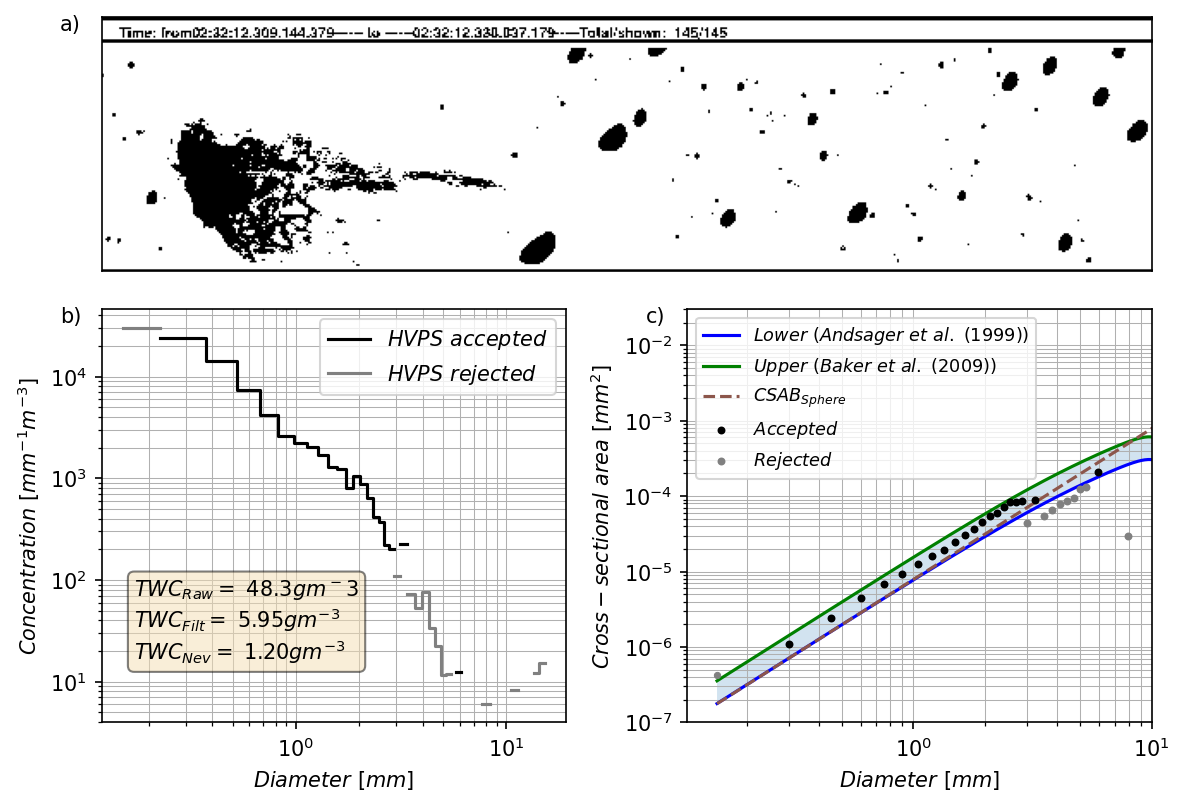

In [23]:
# Create and define the layout
fig, axs = plt.subplot_mosaic([['a)', 'a)'], ['b)', 'c)']], figsize=(8,6), dpi=150)

# In the top row show the HVPS raw image
path_img = f'{path}/data/CAMP2Ex_HVPS_P3B_V_20190907_023212_276415_RA.png'
img = np.asarray(Image.open(path_img))
ax0  = axs["a)"]
ax0.imshow(cv2.cvtColor(img[292:440, :], cv2.COLOR_BGR2RGB))
ax0.xaxis.set_tick_params(labelbottom=False)
ax0.yaxis.set_tick_params(labelleft=False)
ax0.set_xticks([])
ax0.set_yticks([])

# Plot PSD along with LWC quantities
ax1 = axs['b)']
ax1.step(x=xr_hvps.diameter* 1e-3, y=yyes, where='mid', label='$HVPS \ accepted$', c='k')
ax1.step(x=xr_hvps.diameter* 1e-3, y=ynot, where='mid', c='grey', label='$HVPS \ rejected$')
ax1.step(x=xr_hvps.diameter* 1e-3, y=ynot2, where='mid', c='grey')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(which='both', lw=0.5)
ax1.set_ylabel('$Concentration \ [mm^{-1} m^{-3}]$')
ax1.set_xlabel('$Diameter \ [mm]$')
ax1.legend(fontsize=10)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax1.text(0.07, 0.35, "$TWC_{Raw}= \ $" + f'{lwc_raw_tot:.1f}' + f'$gm^{-3}$' + '\n' + 
         "$TWC_{Filt}=\  $" + f"{lwc_filtered:.2f}" + '$gm^{-3}$' + '\n' +
         "$TWC_{Nev}=\  $" + f"{lwc_nev:.2f}" + '$gm^{-3}$',
        transform=ax1.transAxes, fontsize=10, verticalalignment='top', bbox=props)


# Plot the CSAB filter rejectec particles
ax = axs['c)']
ax.plot(diameter,area/1e5 * alpha, c='b', label='$Lower \ (Andsager \ et \  al. \ (1999))$')
ax.plot(diameter,area/1e5 * alpha * 2, c='g', label='$Upper \  (Baker \  et \  al. \  (2009))$')
ax.plot(diameter , area/1e5,  color='tab:brown', ls='--', label='$CSAB_{Sphere}$')
ax.fill_between(diameter, 
                area/1e5 * alpha , 
                area/1e5 * alpha * 2, alpha=0.2)

ax.scatter(xr_hvps.diameter / 1e3, csab_in, 
               zorder=2.5, c='k', lw=0.8, marker='.', label='$Accepted$')
ax.scatter(xr_hvps.diameter / 1e3, csab_low, 
               zorder=2.5, c='gray', lw=0.8, marker='.', label='$Rejected$')
ax.scatter(xr_hvps.diameter / 1e3, csab_up, 
               zorder=2.5, c='gray', lw=0.5, marker='.')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$Cross-sectional \ area \ [mm^2]$')
ax.set_xlabel('$Diameter \ [mm]$')
# title = f"{pd.to_datetime(xr_hvps.a_bin.sel(time=time).time.values): %Y-%m-%d %X} UTC - {aircraft}"
# fig.suptitle(title, fontsize=14, fontweight='bold', y=0.95)
ax.set_xlim(0, 10)
ax.set_xlim(0, 10)

ax.legend(loc='upper left', fontsize=8.5)
ax.grid(which='both', lw=0.5)
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-20/72, 1/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
    
fig.tight_layout()
plt.subplots_adjust(wspace=None, hspace=-0.1)
plt.savefig(f'{path}/images/area_based_filter.svg', bbox_inches='tight')

## Adiabatic Liquid water content comparison

Another way to test our CSAB filter is by comparing values with the adiabatic LWC. To achieve this, a dropsonde launched near the analized event is used to compute the adiatatic LWC profile.

In [25]:
def comp_lwc(t, p):
    """
    Compute the adiabatic Liquid Water Content (LWC) for a given temperature and pressure.

    Parameters
    ----------
    t : float or array-like
        Temperature in Kelvin.
    p : float or array-like
        Pressure in hPa.

    Returns
    -------
    cw : float or array-like
        Adiabatic Liquid Water Content (LWC) in g/m^3.

    Notes
    -----
    The adiabatic LWC is computed based on thermodynamic principles and assumes adiabatic ascent,
    where no heat exchange occurs with the surrounding environment. The function calculates the
    adiabatic temperature lapse rate and the density of dry air, incorporating parameters such as
    latent heat, specific heat, and the molar mass ratio of dry air to water vapor.

    The formula is derived from:
      - The Clausius-Clapeyron equation for saturation vapor pressure,
      - Ideal gas law for density,
      - and an adjustment for adiabatic cooling.

    Formula Steps:
    --------------
    1. Calculate the saturation vapor pressure (`es`) based on the Clausius-Clapeyron relation.
    2. Compute the mixing ratio (`r`) using the molar mass ratio of dry air to water vapor.
    3. Determine the dry adiabatic lapse rate (`gamma_d`).
    4. Compute the moist adiabatic lapse rate (`gamma_m`), adjusting for the presence of water vapor.
    5. Calculate the air density (`rho_a`) from the ideal gas law.
    6. Finally, compute the adiabatic liquid water content (`cw`), expressed in g/m^3.

    Constants
    ---------
    g : float
        Gravitational acceleration, in m/s^2.
    cp : float
        Specific heat of dry air at constant pressure, in J/(kg·K).
    Rd : float
        Specific gas constant for dry air, in J/(kg·K).
    Rv : float
        Specific gas constant for water vapor, in J/(kg·K).
    L : float
        Latent heat of vaporization, in J/kg.

    Examples
    --------
    >>> t = 273.15 + 8.0  # Temperature in Kelvin
    >>> p = 900.0  # Pressure in hPa
    >>> comp_lwc(t, p)
    0.153  # Example output in g/m^3

    """
    
    g = 9.8076
    cp = 1004.0
    Rd = 287.0
    Rv = 461.5
    L = 2.5e6
    es = 6.112 * np.exp(17.67 * (t - 273.15) / (243.5 + (t - 273.15)))
    molar_mass_ratio = 1.0 / 1.608  # Rd/Rv
    r = molar_mass_ratio * es / p
    gamma_d = -g / cp
    gamma_m = gamma_d * (1.0 + L * r / (Rd * t)) / (1 + L ** 2 * r / (cp * Rv * t ** 2))
    rho_a = 100.0 * p / (Rd * t)  # hPa back to Pa for density calculation
    cw = rho_a * (cp / L) * (gamma_m - gamma_d)  # 1e3 for units. End result in g/m^3
    return cw


In [26]:
# setting up the Seaborne style including figure  dpi
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(style='white', font_scale=0.9)
sns.set_style("ticks")

Let's read the dropsonde information available [here](https://vandenheever.atmos.colostate.edu/vdhpage/camp2ex/dropsondes_rev1.php?flt_nm=2019-09-06_SF06#:~:text=S03_vicinity_strong_conv)

In [27]:
dropsonde = xr.open_dataset(f'{path}/data/CAMP2EX_AVAPS_RD41_v1_20190907_030551.nc')

Extract the values needed for adiabatic LWC calculation

In [28]:
# Extract pressure, temperature, and dew point temperature from the dropsonde data,
# removing any rows with NaN values along the 'time' dimension
p = dropsonde.dropna('time')['pres']  # Pressure in hPa
t = dropsonde.dropna('time')['tdry']  # Temperature in degrees Celsius
dp = dropsonde.dropna('time')['dp']    # Dew point temperature in degrees Celsius

# Calculate the Lifted Condensation Level (LCL) pressure and temperature
# `lcl_p` is the pressure at LCL, and `lcl_t` is the temperature at LCL
lcl_p, lcl_t = lcl(p, t, dp)

# Determine the Cloud Base Height (CBH) by converting the LCL pressure to height
# using the `p2h` function. This calculates the height above sea level where clouds form.
cbh = p2h(lcl_p[0])

# Filter the dropsonde data to include only values below the LCL pressure level
# This ensures we are analyzing atmospheric conditions below the cloud base.
dropsonde = dropsonde.where(dropsonde.pres < lcl_p[0].m)

# Re-extract pressure, temperature, and dew point temperature after applying the LCL filter
# and dropping any remaining NaN values along the 'time' dimension
p = dropsonde['pres'].dropna('time')
t = dropsonde['tdry'].dropna('time')
dp = dropsonde['dp'].dropna('time')

# Convert the filtered pressure values to height above sea level using the `p2h` function
# This provides the altitude in meters corresponding to each pressure level.
h = p2h(p)

# Calculate the adiabatic liquid water content (LWC) at each height level.
# The temperature is converted to Kelvin by adding 273.15 before passing to `comp_lwc`.
adia_lwc = comp_lwc(t.values + 273.15, p.values)

# Compute the cumulative sum of adiabatic LWC across the height levels
# This approximates the total liquid water path below the cloud base.
# The result is scaled by 1e6 to ensure units consistency (g/m^3).
adia_lwc_sum = np.cumsum(adia_lwc[:-1] * h.diff('time').values * 1e6)


Now we can create an `xarray.Dataset` with the adiabatic results

In [29]:
ds_adiabatic = xr.Dataset(
    {
        "adia_lwc": (("height",), adia_lwc[:-1]),
        "adia_lwc_sum": (("height",), adia_lwc_sum)
    },
    coords={"height": h.values[:-1] * 1000}  # Use 'height' as the dimension
)
ds_adiabatic

<xarray.Dataset> Size: 11kB
Dimensions:       (height: 900)
Coordinates:
  * height        (height) float32 4kB 486.3 491.0 495.6 ... 5.331e+03 5.337e+03
Data variables:
    adia_lwc      (height) float32 4kB 2.68e-06 2.678e-06 ... 1.18e-06 1.179e-06
    adia_lwc_sum  (height) float32 4kB 0.01246 0.025 0.05027 ... 9.097 9.104

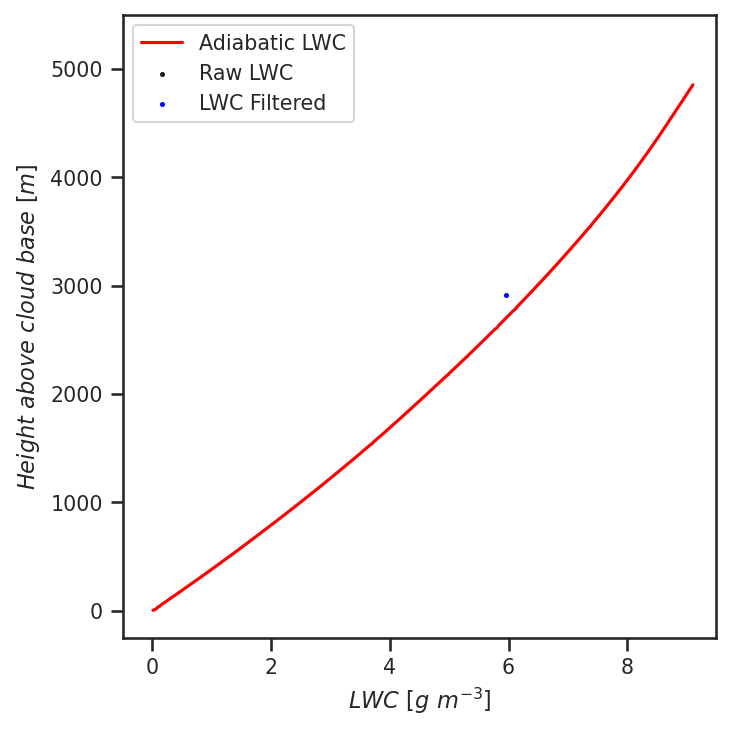

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))

# height relative to the cloud base
heigth = ds_adiabatic.height - cbh.m * 1000

ax.plot(ds_adiabatic.adia_lwc_sum, heigth, c="red", label="Adiabatic LWC")

# altitude of the plane relative to the cloud base
alt_cb = xr_hvps.alt.sel(time=time) - cbh.m * 1000
# Plotting filtered data points
ax.scatter(x=lwc_raw_tot, y=alt_cb, color="k", s=2, label="Raw LWC")
ax.scatter(x=lwc_filtered, y=alt_cb, color="blue", s=2, label="LWC Filtered")

# Labels and limits
ax.set_xlabel("$LWC \ [g \  m^{-3}]$")
ax.set_ylabel("$Height \ above \ cloud \ base \ [m]$")
ax.set_ylim(-250, 5500)
ax.set_xlim(-0.5, 9.5)

# Adding legend
ax.legend()
fig.tight_layout()
plt.savefig('../images/adiabatic_lwc.png',  bbox_inches='tight')
plt.show()

From this plot we can conclude our filtered LWC ($5.95$ $g \ m^{-3}$) is less than the adiabatic LWC ($6.33$ $g \ m^{-3}$)

In [31]:
# altitude of the plane relative to the ground
alt_ground = xr_hvps.alt.sel(time=time)

In [32]:
ds_adiabatic.adia_lwc_sum.sel(height=alt_ground, method="nearest").values

array(6.330745, dtype=float32)

In [33]:
lwc_filtered

array(5.95016012)